# Nonlinear PDE

Our goal is to solve the following nonlinear PDE:

$$ - \Delta u(x) + u(x)^3 = f(x), \quad x \in \Omega $$
$$ u(x) = g(x), \quad x\in\partial\Omega$$


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time

torch.set_default_dtype(torch.float64)

In [52]:
def sample_points(N_pts):
    """
    Generate interior and boundary points.
    """
    # interior points
    N_domain_tot = N_pts**2
    x_int_train = torch.rand(N_domain_tot, 1, requires_grad=True)
    y_int_train = torch.rand(N_domain_tot, 1, requires_grad=True)
    
    # boundary
    # bottom points
    x_bottom = torch.rand(N_pts+1, 1)
    y_bottom = torch.zeros(N_pts+1, 1)
    # top points
    x_top = torch.rand(N_pts+1, 1)
    y_top = torch.ones(N_pts+1,1)
    # concatenate
    x_bound_train = torch.concat((x_bottom, x_top))
    y_bound_train = torch.concat((y_bottom, y_top))
    # left points
    x_left = torch.zeros(N_pts+1,1)
    y_left = torch.rand(N_pts+1,1)
    # concat
    x_bound_train = torch.concat((x_bound_train, x_left))
    y_bound_train = torch.concat((y_bound_train, y_left))
    # right points
    x_right = torch.ones(N_pts+1,1)
    y_right = torch.rand(N_pts+1,1)
    # concat
    x_bound_train = torch.concat((x_bound_train, x_right))
    y_bound_train = torch.concat((y_bound_train, y_right))
    
    return x_int_train, y_int_train, x_bound_train, y_bound_train


def u_true(x, y):
    """
    Define true solution of the PDE.
    """
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y) + 2*torch.sin(4*torch.pi*x) * torch.sin(4*torch.pi*y)

def f(x, y):
    """
    Define RHS of the PDE.
    """
    u = u_true(x,y)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    return - u_xx - u_yy + u**3

def g(x,y):
    """
    Define the boundary condition of the PDE.
    """
    return u_true(x,y)

In [3]:
class RF_PDE(nn.Module):
    """
    Random feature model
    """
    
    def __init__(self, in_features, out_features, sigma=1.0):
        super(RF_PDE, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.sigma = sigma
        self.W = nn.Parameter(torch.randn(in_features, out_features) / sigma, requires_grad=False)
        self.b = nn.Parameter(torch.rand(out_features) * 2 * torch.pi, requires_grad=False)
        
        self.model = nn.Sequential(nn.Linear(out_features, 1))
    
    def forward(self,x,y):
        
        inputs = torch.cat((x,y), dim=1)
        u = self.model(torch.cos(inputs @ self.W + self.b) * torch.sqrt( torch.tensor([2 / self.out_features])))
        return u
    
    
class PINN(nn.Module):
    """
    Physics-informed neural network
    """    
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
        nn.Linear(2,64),
        nn.Tanh(),
        nn.Linear(64,64),
        nn.Tanh(),
        nn.Linear(64,1))
        
    def forward(self,x,y):
        
        inputs = torch.cat((x,y), dim=1)
        u = self.model(inputs)
        return u
    
    
def loss_fn(model, x_int, y_int, x_bound, y_bound, RHS, g):
    """
    Compute the loss
    """
    
    # interior:
    u = model(x_int,y_int)
    u_x = torch.autograd.grad(u, x_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_int, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_int, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
    f = RHS(x_int,y_int)
    
    residual = - u_xx - u_yy + u**3 - f
    
    # boundary
    residual_bound = model(x_bound, y_bound) - g(x_bound, y_bound)

    return torch.mean(residual**2) + torch.tensor([1e6]) * torch.mean(residual_bound**2)

def train(model, optimizer, x_int, y_int, x_bound, y_bound, RHS, g, epochs=1000):
    """
    Train models
    """
    losses = []
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        loss = loss_fn(model, x_int, y_int, x_bound, y_bound, RHS, g)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return losses

## Comparison on time and visualization

In this section, we compare the computational times of RF and PINN. Then, we visualize the result of RF.

In [4]:
# generate training points
N_pts = 30
x_int_train, y_int_train, x_bound_train, y_bound_train = sample_points(N_pts)

################### Random Feature 
# initialize Random Feature model and optimizer
N = 1000
model_RF = RF_PDE(2, N, sigma = 0.1)
optimizer = optim.Adam(model_RF.parameters(), lr=1e-2)
# Train the model
start = time.time()
losses = train(model_RF, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

Epoch 0, Loss: 101374.71205472044
Computational time is 82.12 seconds


In [5]:
# generate test samples
num_pts = 100
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)

XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)
XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)

u_truth = u_true(XX,YY)
u_truth = u_truth.detach().numpy()

# prediction by Random Feature model
RF_pred = model_RF(XX_test, YY_test)
RF_pred = RF_pred.detach().numpy()
RF_pred = RF_pred.reshape(num_pts,num_pts)

err_RF = np.sum( (u_truth - RF_pred)**2 ) / np.size(u_truth)
print(f'Test error of RF model is {err_RF:.2e}')

Test error of RF model is 6.80e-05


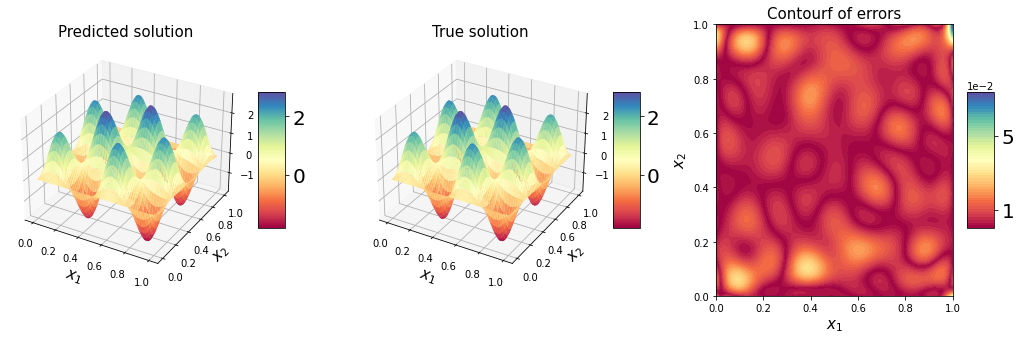

In [6]:
## visualization

fig = plt.figure(figsize=(18,5))
# plot the true solution
ax = fig.add_subplot(132, projection='3d')
u_truth_surf=ax.plot_surface(XX, YY, u_truth, cmap='Spectral')
plt.xlabel(r'$x_1$', fontsize=15); 
plt.ylabel(r'$x_2$', fontsize=15); 
plt.title('True solution', size=15)
cbar = fig.colorbar(u_truth_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot the test solution
ax = fig.add_subplot(131, projection='3d')
u_test_surf=ax.plot_surface(XX, YY, RF_pred, cmap='Spectral')
plt.xlabel(r'$x_1$', fontsize=15); 
plt.ylabel(r'$x_2$', fontsize=15); 
plt.title('Predicted solution', size=15)
cbar = fig.colorbar(u_test_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot error
ax = fig.add_subplot(133)
u_contourf=ax.contourf(XX, YY, abs(u_truth-RF_pred), 50, cmap='Spectral')
plt.xlabel(r'$x_1$', fontsize=15); 
plt.ylabel(r'$x_2$', fontsize=15); 
plt.title('Contourf of errors',size=15)
cbar = fig.colorbar(u_contourf, shrink= 0.5, aspect = 5, ticks=[0.01,0.05])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=20)
#plt.savefig('Nonlinear_PDE.pdf', bbox_inches = 'tight')

In [7]:
################### PINN: 1000 epochs
# initialize model and optimizer
model_PINN = PINN()
optimizer = optim.Adam(model_PINN.parameters(), lr=1e-2)

# Train the model
start = time.time()
losses = train(model_PINN, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

## test and prediction
PINN_pred = model_PINN(XX_test, YY_test)
PINN_pred = PINN_pred.detach().numpy()
PINN_pred = PINN_pred.reshape(num_pts,num_pts)

err_PINN = np.sum( (u_truth - PINN_pred)**2 ) / np.size(u_truth)
print(f'Test error of PINN model is {err_PINN:.2f}')

Epoch 0, Loss: 115550.6420464484
Computational time is 14.20 seconds
Test error of PINN model is 1.22


In [8]:
################### PINN: 10000 epochs
# initialize model and optimizer
model_PINN = PINN()
optimizer = optim.Adam(model_PINN.parameters(), lr=1e-2)

# Train the model
start = time.time()
losses = train(model_PINN, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=10000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

## test and prediction
PINN_pred = model_PINN(XX_test, YY_test)
PINN_pred = PINN_pred.detach().numpy()
PINN_pred = PINN_pred.reshape(num_pts,num_pts)

err_PINN = np.sum( (u_truth - PINN_pred)**2 ) / np.size(u_truth)
print(f'Test error of PINN model is {err_PINN:.2f}')

Epoch 0, Loss: 102241.87649679378
Epoch 1000, Loss: 100546.81012554449
Epoch 2000, Loss: 100546.33469622122
Epoch 3000, Loss: 100543.6425302836
Epoch 4000, Loss: 66101.13117697368
Epoch 5000, Loss: 45274.02584297774
Epoch 6000, Loss: 15567.053783139761
Epoch 7000, Loss: 6955.271293550183
Epoch 8000, Loss: 3356.7407133837014
Epoch 9000, Loss: 2238.4859010300866
Computational time is 141.82 seconds
Test error of PINN model is 0.03


## Extreme Learning Machine (ELM)

In [9]:
class ELM_PDE(nn.Module):
    """
    Extreme Learning Machine.
    """
    
    def __init__(self, in_features, out_features, R):
        super(ELM_PDE, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.R = R
        self.W = nn.Parameter(torch.rand(in_features, out_features) * 2 * R - R , requires_grad=False)
        
        self.model = nn.Sequential(nn.Linear(out_features, 1))
    
    def forward(self,x,y):
        
        inputs = torch.cat((x,y), dim=1)
        u = self.model(torch.tanh(inputs @ self.W))
        return u

In [10]:
################### ELM
# initialize ELM model and optimizer
N = 1000
model_ELM = ELM_PDE(2, N, R = 0.05)
optimizer = optim.Adam(model_ELM.parameters(), lr=1e-2)
# Train the model
start = time.time()
losses = train(model_ELM, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

Epoch 0, Loss: 100563.19182231447
Computational time is 57.95 seconds


In [11]:
## test and prediction
ELM_pred = model_ELM(XX_test, YY_test)
ELM_pred = ELM_pred.detach().numpy()
ELM_pred = ELM_pred.reshape(num_pts,num_pts)

err_ELM = np.sum( (u_truth - ELM_pred)**2 ) / np.size(u_truth)
print(f'Test error of ELM model is {err_ELM:.2f}')

Test error of ELM model is 1.23


In [14]:
################### ELM
# initialize ELM model and optimizer
N = 1000
model_ELM = ELM_PDE(2, N, R = 0.01)
optimizer = optim.Adam(model_ELM.parameters(), lr=1e-2)
# Train the model
start = time.time()
losses = train(model_ELM, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

## test and prediction
ELM_pred = model_ELM(XX_test, YY_test)
ELM_pred = ELM_pred.detach().numpy()
ELM_pred = ELM_pred.reshape(num_pts,num_pts)

err_ELM = np.sum( (u_truth - ELM_pred)**2 ) / np.size(u_truth)
print(f'Test error of ELM model is {err_ELM:.2f}')

Epoch 0, Loss: 101468.78539213582
Computational time is 65.07 seconds
Test error of ELM model is 1.23


In [15]:
################### ELM
# initialize ELM model and optimizer
N = 1000
model_ELM = ELM_PDE(2, N, R = 0.01)
optimizer = optim.Adam(model_ELM.parameters(), lr=1e-2)
# Train the model
start = time.time()
losses = train(model_ELM, optimizer, x_int_train,y_int_train, x_bound_train, y_bound_train, f, g, epochs=2000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')

## test and prediction
ELM_pred = model_ELM(XX_test, YY_test)
ELM_pred = ELM_pred.detach().numpy()
ELM_pred = ELM_pred.reshape(num_pts,num_pts)

err_ELM = np.sum( (u_truth - ELM_pred)**2 ) / np.size(u_truth)
print(f'Test error of ELM model is {err_ELM:.2f}')

Epoch 0, Loss: 100573.9561649437
Epoch 1000, Loss: 100546.58294747084
Computational time is 126.82 seconds
Test error of ELM model is 1.23


###### Non-linear least squares

In [53]:
## Jacobian

def Jacobian(c):
    
    # value 1
    A1 = 3*(A_int @ c) ** 2
    A1 = A1.reshape((A1.shape[0],1))
    
    # stack
    J = np.row_stack((delta_u + A_int*A1, A_bd))
    return J

def G(c):
    
    # value 1: PDE loss
    value1 = delta_u @ c + (A_int @ c) ** 3 - rhs_pde.detach().numpy().reshape(-1)
    
    # value 2:
    value2 = A_bd @ c - rhs_bd.detach().numpy().reshape(-1)
    
    return np.concatenate((value1, value2))
    

In [58]:
# generate training points
N_pts = 30
x_int_train, y_int_train, x_bound_train, y_bound_train = sample_points(N_pts)

# compute rhs
rhs_pde = f(x_int_train, y_int_train)
rhs_bd = g(x_bound_train, y_bound_train)

# generate weights
N = 1000                               # number of random features
R = 5
W = np.random.uniform(-R,R, size=(2,N))
W_norm = np.linalg.norm(W,axis=0) ** 2

x_train = torch.cat((x_int_train,y_int_train), dim=1)
x_train = x_train.detach().numpy()
A_int = np.tanh(x_train @ W)

x_bd = torch.cat((x_bound_train,y_bound_train), dim=1)
x_bd = x_bd.detach().numpy()
A_bd = np.tanh(x_bd @ W)


# some matrices
delta_u = 2 * A_int * (1-A_int**2) * W_norm


# generate test samples
num_pts = 100
xx= np.linspace(0, 1, num_pts)
yy = np.linspace(0, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)

XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)
XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)

u_truth = u_true(XX,YY)
u_truth = u_truth.detach().numpy()

# A_test
x_test = torch.cat((XX_test,YY_test), dim=1)
x_test = x_test.detach().numpy()
A_test = np.tanh(x_test @ W)

# Initial guess for parameters
#c = np.zeros((N,))
c = np.random.rand(N)
# Iter 100 times
Iter = 50
# test error
test_err = []
start = time.time()
for i in range(Iter):
    
    J = Jacobian(c)
    rhs = G(c)
    
    delta_c = np.linalg.pinv(J) @ (-rhs)
    c = c + delta_c

    ELM_pred = A_test @ c
    ELM_pred = ELM_pred.reshape(num_pts, num_pts)

    err_ELM = np.sum( (u_truth - ELM_pred)**2 ) / np.size(u_truth)
    test_err.append(err_ELM)
end = time.time()

print(f'Test error of RF model is {min(test_err):.2e}')
print(f'Training time is {end-start:.2f} seconds')

Test error of RF model is 5.39e-03
Training time is 9.71 seconds


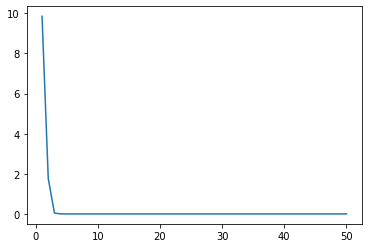

In [59]:
import matplotlib.pyplot as plt
plt.plot(range(1,Iter+1),test_err)

In [49]:
## RF model trained by non-linear least square
N = 1000
sigma = 0.1

# random features
W = np.random.randn(2,N) / sigma
W_norm = np.linalg.norm(W,axis=0) ** 2

b = np.random.uniform(0, 2*np.pi, N)

# matrix A
A_int = np.cos(x_train @ W + b)
A_bd = np.cos(x_bd @ W + b)
A_test = np.cos(x_test @ W + b)

# some matrices
delta_u = A_int * W_norm

# Initial guess for parameters
c = np.zeros((N,))
#c = np.random.rand(N)
# Iter 100 times
Iter = 30
# test error
test_err = []
start = time.time()
for i in range(Iter):
    
    J = Jacobian(c)
    rhs = G(c)
    
    delta_c = np.linalg.pinv(J) @ (-rhs)
    c = c + delta_c

    ELM_pred = A_test @ c
    ELM_pred = ELM_pred.reshape(num_pts, num_pts)

    err_ELM = np.sum( (u_truth - ELM_pred)**2 ) / np.size(u_truth)
    test_err.append(err_ELM)
end = time.time()
print(f'Test error of RF model is {min(test_err):.2e}')
print(f'Training time is {end-start:.2f} seconds')

Test error of RF model is 2.59e-06
Training time is 6.46 seconds


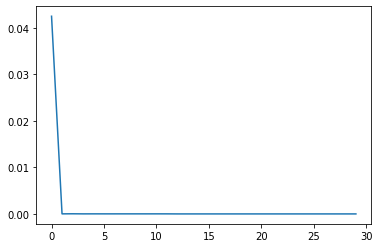

In [50]:
plt.plot(test_err)